# **DATA PROCESSING**

### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [2]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_UG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_UG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '/content/drive/MyDrive/Colab Notebooks/CW_Folder_UG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Code', '.DS_Store', 'Models', 'CW_Dataset', 'Personal_Dataset', 'test_functions.ipynb']


# Load packages

In the next cell you should load all the packages required to test your functions.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

%matplotlib inline

In [4]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


# Loading the Data

In [5]:
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Load dataset
def load_dataset(root_dir):
    img_dir = os.path.join(root_dir, 'images')
    labels_dir = os.path.join(root_dir, 'labels')
    img_paths = [os.path.join(img_dir, img_name) for img_name in os.listdir(img_dir) if img_name.endswith(('.jpg', '.jpeg', '.png'))]
    labels = [int(open(os.path.join(labels_dir, os.path.splitext(img_name)[0] + '.txt'), 'r').read().strip()) for img_name in os.listdir(img_dir)]

    return img_paths, labels

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}

# Load and split the data
data_dir = '/content/drive/MyDrive/Colab Notebooks/CW_Folder_UG/CW_Dataset/train'
img_paths, labels = load_dataset(data_dir)
img_paths_train, img_paths_val, labels_train, labels_val = train_test_split(img_paths, labels, test_size=0.2, shuffle=True, stratify=labels)

# Address class imbalance for the training set using RandomOverSampler
ros = RandomOverSampler(random_state=42)
img_paths_train_res, labels_train_res = ros.fit_resample(np.array(img_paths_train).reshape(-1, 1), labels_train)
img_paths_train_res = img_paths_train_res.flatten()  # Flatten back to original shape

# Create datasets
train_dataset = CustomDataset(img_paths_train_res, labels_train_res, data_transforms['train'])
val_dataset = CustomDataset(img_paths_val, labels_val, data_transforms['val'])

# Create dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=True)
}

# Print sizes of datasets
print("Training set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))


Training set size: 4656
Validation set size: 479


# Visualizing a few images

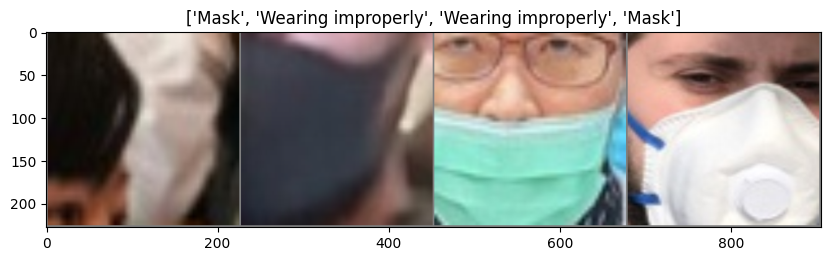

In [6]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Define the mapping from class index to class name
class_names = {0: 'No Mask', 1: 'Mask', 2: 'Wearing improperly'}

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Directly adjust the normalization knowing that mean=0.5 and std=0.5 were used
    inp = inp * 0.5 + 0.5  # Reversing the normalization: (inp - mean) / std -> inp * std + mean
    inp = np.clip(inp, 0, 1)  # Ensure the pixel values are between 0 and 1
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


# Get a batch of training data
first_inputs, first_classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(first_inputs)

# Convert class indices to class names for titles, using the class_names mapping
titles = [class_names[x.item()] for x in first_classes]

plt.figure(figsize=(10, 15))
imshow(out, title=(titles))
plt.show()


#CNN ResNet18

In [7]:
import torch
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Update dataset_sizes dictionary to handle oversampled training size
    dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
import torch
import torchvision.models as models
from torch import nn, optim
from torch.optim import lr_scheduler

model_ft = models.resnet18(weights='IMAGENET1K_V1')
# Load a pretrained ResNet-18 model
model_conv = models.resnet18(pretrained=True)

# Freeze all the layers in the model
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
# Replace the final fully connected layer
model_conv.fc = nn.Linear(num_ftrs, 3)

# Move the model to the specified device (GPU or CPU)
model_conv = model_conv.to(device)

# Specify the loss function
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Set up the learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.3MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# Train the model
model_ft = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9377 Acc: 0.6194
val Loss: 0.4847 Acc: 0.8121

Epoch 1/24
----------
train Loss: 0.9473 Acc: 0.6093
val Loss: 0.4634 Acc: 0.8225

Epoch 2/24
----------
train Loss: 0.9777 Acc: 0.5966
val Loss: 0.7196 Acc: 0.7119

Epoch 3/24
----------
train Loss: 1.0173 Acc: 0.6029
val Loss: 1.1805 Acc: 0.5157

Epoch 4/24
----------
train Loss: 0.9654 Acc: 0.6125
val Loss: 0.2830 Acc: 0.8977

Epoch 5/24
----------
train Loss: 1.0064 Acc: 0.6012
val Loss: 0.5608 Acc: 0.7724

Epoch 6/24
----------
train Loss: 0.7656 Acc: 0.6757
val Loss: 0.4837 Acc: 0.8205

Epoch 7/24
----------
train Loss: 0.7519 Acc: 0.6787
val Loss: 0.4107 Acc: 0.8392

Epoch 8/24
----------
train Loss: 0.7864 Acc: 0.6660
val Loss: 0.4251 Acc: 0.8330

Epoch 9/24
----------
train Loss: 0.7749 Acc: 0.6686
val Loss: 0.4352 Acc: 0.8372

Epoch 10/24
----------
train Loss: 0.7502 Acc: 0.6757
val Loss: 0.4616 Acc: 0.8225

Epoch 11/24
----------
train Loss: 0.7571 Acc: 0.6682
val Loss: 0.5428 Acc: 0.7724

Ep

In [12]:
import matplotlib.pyplot as plt
import torch

# Define class names based on the dataset's specific classes
class_names = {0: 'No Mask', 1: 'Mask', 2: 'Wearing improperly'}

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = (inp * 0.5) + 0.5  # Unnormalize using the same factor used during normalization
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(10, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j].item()]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.show()
                    return
        model.train(mode=was_training)


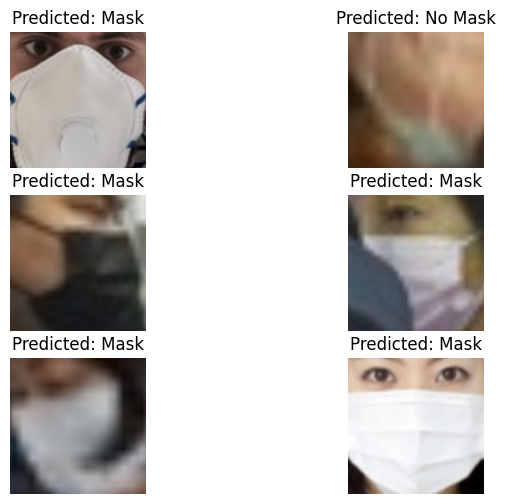

In [13]:
import matplotlib.pyplot as plt
import torch

# Define the class names
class_names = {0: 'No Mask', 1: 'Mask', 2: 'Wearing improperly'}

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # Reorder dimensions to HxWxC
    inp = (inp * 0.5) + 0.5  # Unnormalize
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far < num_images:
                    images_so_far += 1
                    ax = plt.subplot(num_images // 2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title(f"Predicted: {class_names[preds[j].item()]}")
                    imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Call the visualization function
plt.figure(figsize=(8, 6))
visualize_model(model_conv)
plt.show()


# Saving the Model

In [14]:
import os
import torch

# Directory where the model will be saved
model_dir = '/content/drive/MyDrive/Colab Notebooks/CW_Folder_UG/Models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Path to save the model file
model_path = os.path.join(model_dir, 'CNN.pth')


torch.save(model_ft.state_dict(), model_path)

print(f"Model saved successfully at {model_path}")

Model saved successfully at /content/drive/MyDrive/Colab Notebooks/CW_Folder_UG/Models/CNN.pth
